# Detailed Comparision of all 3 trained models (SVM/ANN/CNN)

# 1. Import Required Libraries

In [4]:
import os
import cv2
import glob
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve
)

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

# 2. Define path, input size and load models

In [7]:
# Dataset paths
pos_path = "../data/pos_person"
neg_path = "../data/neg_person"

# Image input size
img_size = (64, 128)

# Load models
svm_model = joblib.load("../model/svm_model.pkl")
ann_model = load_model("../model/human_detector_ann.h5")
cnn_model = load_model("../model/human_detector_cnn.h5")

# 3. Preprocess Data for all models

In [10]:
X_svm, X_ann, X_cnn, y = [], [], [], []
hog = cv2.HOGDescriptor()

# Load positive (label = 1)
for file in os.listdir(pos_path):
    path = os.path.join(pos_path, file)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    img = cv2.resize(img, img_size)
    norm_img = img / 255.0

    X_svm.append(hog.compute(img).reshape(-1))
    X_ann.append(norm_img.flatten())
    X_cnn.append(norm_img.reshape(128, 64, 1))
    y.append(1)

# Load negative (label = 0)
for file in os.listdir(neg_path):
    path = os.path.join(neg_path, file)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    img = cv2.resize(img, img_size)
    norm_img = img / 255.0

    X_svm.append(hog.compute(img).reshape(-1))
    X_ann.append(norm_img.flatten())
    X_cnn.append(norm_img.reshape(128, 64, 1))
    y.append(0)

# Convert to numpy arrays
X_svm = np.array(X_svm)
X_ann = np.array(X_ann)
X_cnn = np.array(X_cnn)
y = np.array(y)

print("X_svm shape:", X_svm.shape)
print("X_ann shape:", X_ann.shape)
print("X_cnn shape:", X_cnn.shape)
print("Labels shape:", y.shape)

X_svm shape: (6562, 3780)
X_ann shape: (6562, 8192)
X_cnn shape: (6562, 128, 64, 1)
Labels shape: (6562,)


# 4. Train/Test Split [ To get X_test for all 3 model for predictions ]

In [13]:
X_train_svm, X_test_svm, y_train, y_test = train_test_split(X_svm, y, test_size=0.2, stratify=y, random_state=42)
_, X_test_ann, _, _ = train_test_split(X_ann, y, test_size=0.2, stratify=y, random_state=42)
_, X_test_cnn, _, _ = train_test_split(X_cnn, y, test_size=0.2, stratify=y, random_state=42)

print("Test samples:", len(y_test))

Test samples: 1313


# 5. Predict  & Classification Report with all 3 Model

In [22]:
# SVM
y_pred_svm = svm_model.predict(X_test_svm)

# ANN
y_pred_ann_prob = ann_model.predict(X_test_ann)
y_pred_ann = (y_pred_ann_prob > 0.5).astype("int32").flatten()

# CNN
y_pred_cnn_prob = cnn_model.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype("int32").flatten()

#Classification Report of all 3 models
print("---------------------- SVM Model -----------------\n", classification_report(y_test, y_pred_svm))
print("---------------------- ANN Model -----------------\n", classification_report(y_test, y_pred_ann))
print("---------------------- CNN Model -----------------\n", classification_report(y_test, y_pred_cnn))

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
---------------------- SVM Model -----------------
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       830
           1       0.95      0.93      0.94       483

    accuracy                           0.96      1313
   macro avg       0.95      0.95      0.95      1313
weighted avg       0.96      0.96      0.95      1313

---------------------- ANN Model -----------------
               precision    recall  f1-score   support

           0       0.87      0.92      0.90       830
           1       0.85      0.77      0.81       483

    accuracy                           0.87      1313
   macro avg       0.86      0.85      0.85      1313
weighted avg       0.86      0.87      0.86      1313

---------------------- CNN Model -----------------
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       830
 

# 6. Plot Confusion Matrices

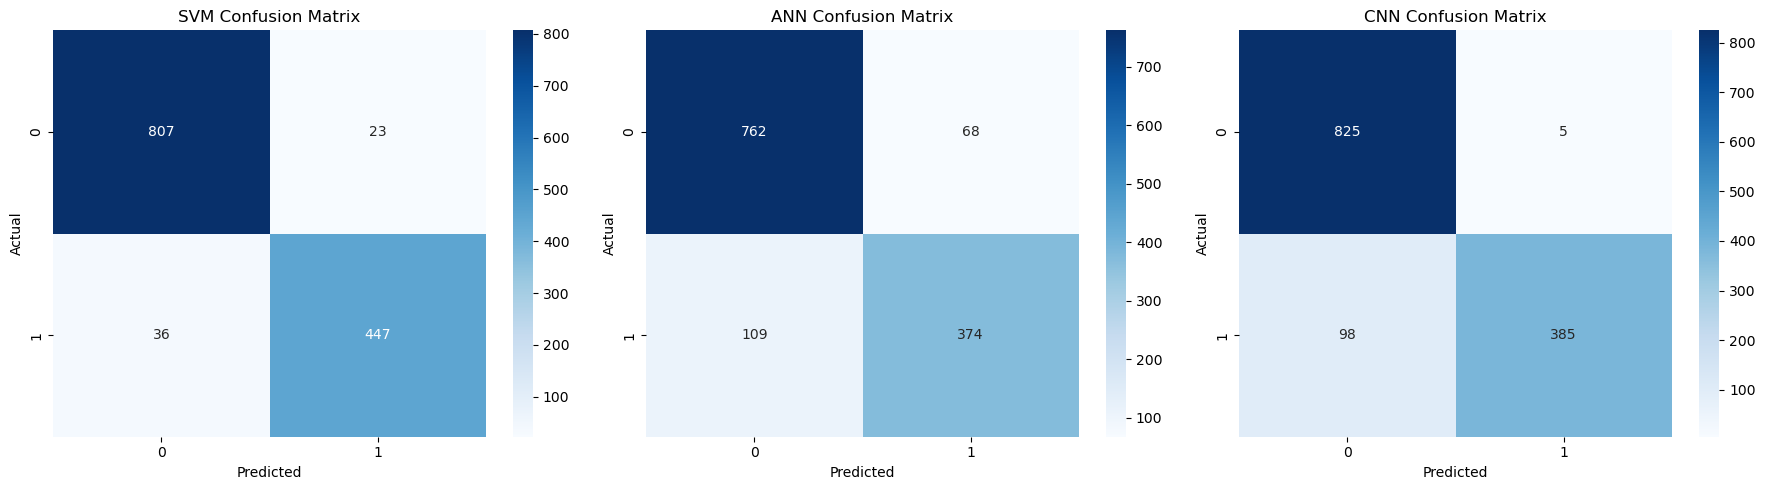

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
models = ['SVM', 'ANN', 'CNN']
preds = [y_pred_svm, y_pred_ann, y_pred_cnn]

for i, (model_name, y_pred) in enumerate(zip(models, preds)):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[i])
    axs[i].set_title(f"{model_name} Confusion Matrix")
    axs[i].set_xlabel("Predicted")
    axs[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# 7. Plot ROC Curves

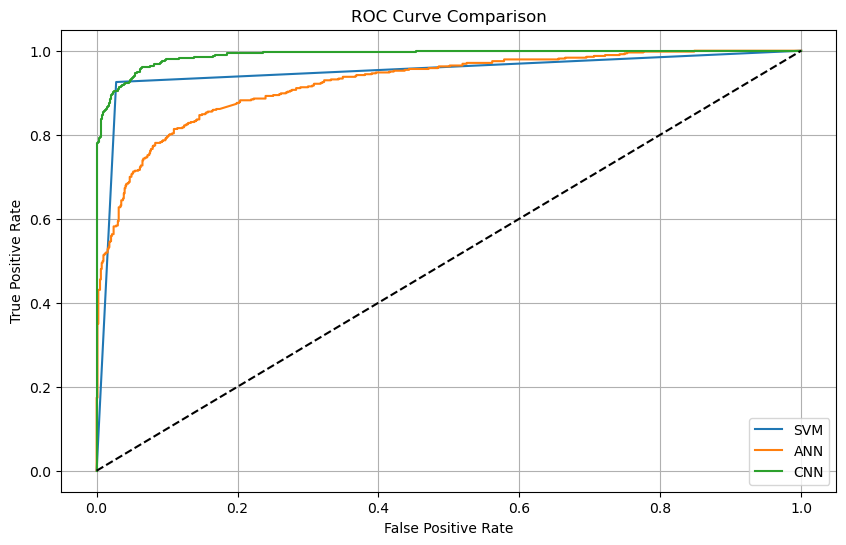

In [28]:
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm.astype(float))
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_pred_ann_prob.flatten())
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn_prob.flatten())

plt.figure(figsize=(10, 6))
plt.plot(fpr_svm, tpr_svm, label="SVM")
plt.plot(fpr_ann, tpr_ann, label="ANN")
plt.plot(fpr_cnn, tpr_cnn, label="CNN")
plt.plot([0, 1], [0, 1], 'k--')

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# 8. Summary Table

In [31]:
summary = {
    "Model": ["SVM", "ANN", "CNN"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_ann),
        accuracy_score(y_test, y_pred_cnn),
    ],
    "Precision": [
        precision_score(y_test, y_pred_svm),
        precision_score(y_test, y_pred_ann),
        precision_score(y_test, y_pred_cnn),
    ],
    "Recall": [
        recall_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_ann),
        recall_score(y_test, y_pred_cnn),
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_ann),
        f1_score(y_test, y_pred_cnn),
    ]
}

df_summary = pd.DataFrame(summary)
df_summary.set_index("Model", inplace=True)
df_summary.style.background_gradient(cmap="YlGnBu")

,Accuracy,Precision,Recall,F1 Score
Model,,,,
SVM,0.955065,0.951064,0.925466,0.938090
ANN,0.865194,0.846154,0.774327,0.808649
CNN,0.921554,0.987179,0.797101,0.882016


# 9. Show sample predictions

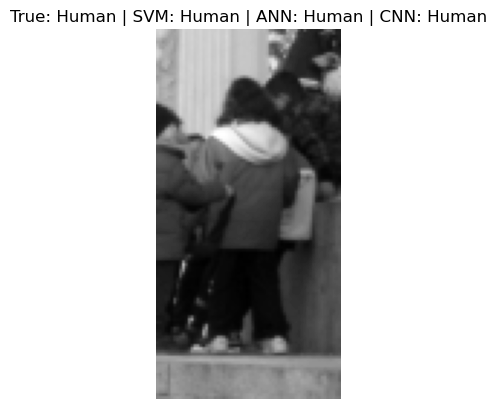

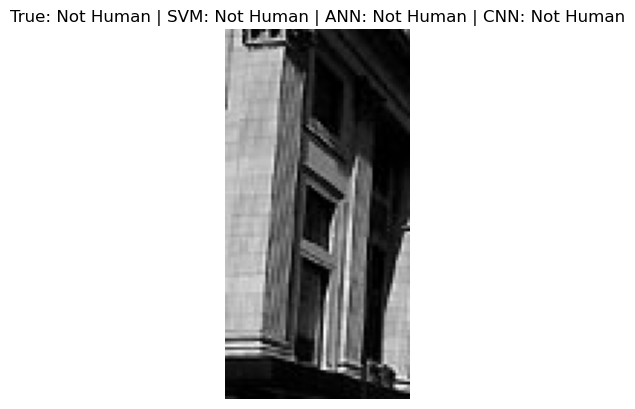

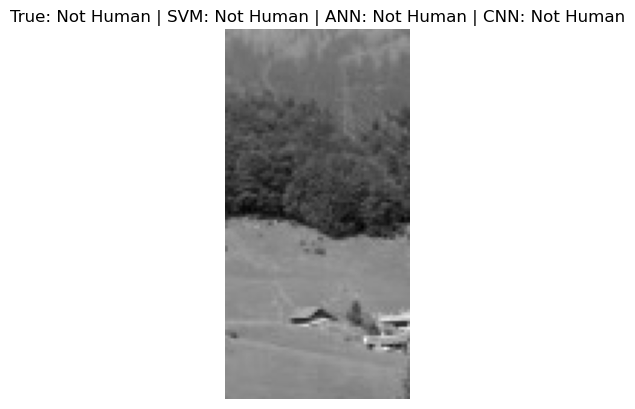

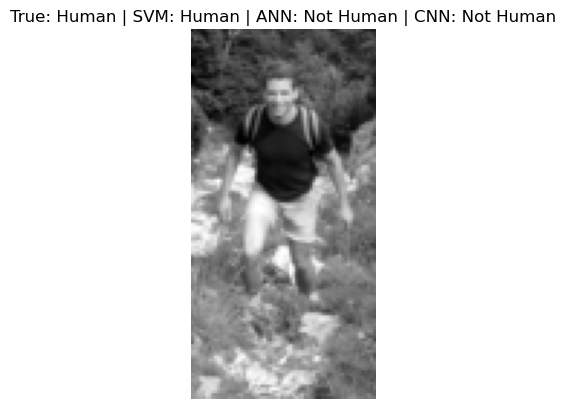

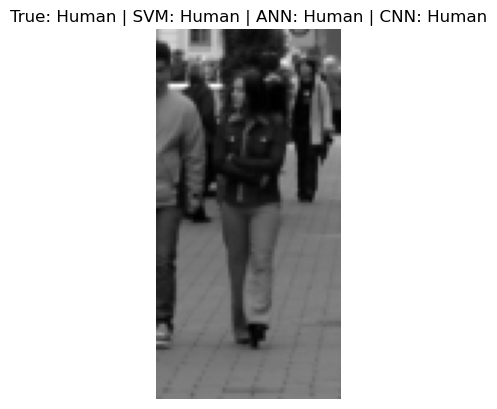

In [34]:
for i in range(5):
    img = X_test_cnn[i].reshape(128, 64)
    true_label = "Human" if y_test[i] == 1 else "Not Human"
    svm_label = "Human" if y_pred_svm[i] == 1 else "Not Human"
    ann_label = "Human" if y_pred_ann[i] == 1 else "Not Human"
    cnn_label = "Human" if y_pred_cnn[i] == 1 else "Not Human"

    plt.imshow(img, cmap="gray")
    plt.title(f"True: {true_label} | SVM: {svm_label} | ANN: {ann_label} | CNN: {cnn_label}")
    plt.axis("off")
    plt.show()